## Pregunta 1 : 
 

*  Desarrolle un modelo de identificación de objetos utilizando el dataset CIFAR10, para imágenes del tamaño de 64x64 pixeles y con 3 canales de colores, utilizando un modelo convolucional que contemple 4 capa convolucionales con sus respectivas capas de pooling, los parámetros para las capas convolucionales serán: kernel = 5, padding = 0, y el strike = 2, para el pooling: kernel = 2, strike = 1, en base a estos datos identificar con cuantas convoluciones se logra el mejor entrenamiento. 



## Importacion de las librerias necesarias 

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
from google.colab import drive
from tqdm import tqdm
import numpy as np
 
 

##Paso 2: Crear una red neuronal


In [ ]:
# Definimos las funciones para construir bloques de convolución y pooling



def block(c_in, c_out, k=5, p=0, s=2, pk=2, ps=1):
    return torch.nn.Sequential(
        torch.nn.Conv2d(c_in, c_out, k, padding=p, stride=s),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(pk, stride=ps)
    )

def block2(c_in, c_out, k=5, p=2, s=2, pk=2, ps=1):
    return torch.nn.Sequential(
        torch.nn.Conv2d(c_in, c_out, k, padding=p, stride=s),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(pk, stride=ps)
    )
# Definimos la arquitectura de nuestra red convolucional
class CNN(torch.nn.Module):
  def __init__(self, n_channels=3, n_outputs=10):
    super().__init__()
    self.conv1 = block(n_channels, 784)
    self.conv2 = block(784, 392)
    self.conv3 = block(392, 196)
    self.conv4 = block2(196, 64)
    self.fc = torch.nn.Linear(64 * 1 * 1, n_outputs)

  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = self.conv4(x)
    x = x.view(x.shape[0], -1)
    x = self.fc(x)
    return x




###### Este modelo utiliza 4 capas convolucionales con kernel de tamaño 5, sin padding y con stride de 2, seguidas de capas de max pooling con kernel de tamaño 2 y stride de 1. Además, se utiliza la función de activación ReLU después de cada capa convolucional y de la capa totalmente conectada fc1. El modelo tiene 10 unidades en la capa de salida, correspondiente a las 10 clases en el dataset CIFAR10.

## Paso 3: Crear un Dataset y cargar datos con DataLoader

In [ ]:
drive.mount('/gdrive')


Mounted at /gdrive


In [ ]:
import sys
sys.path.append('/gdrive/My Drive/dl-pytorch/')


In [ ]:
from plot_helpers import imshow


In [ ]:
 
# Definimos la transformación para el conjunto de datos CIFAR10
transform = transforms.Compose(
    [transforms.Resize((64, 64)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
 

In [ ]:
# Cargamos el conjunto de datos CIFAR10
train_dataset = torchvision.datasets.CIFAR10(root='.', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.CIFAR10(root='.', train=False, transform=transforms.ToTensor(), download=True)

100%|██████████| 170498071/170498071 [00:14<00:00, 11810129.17it/s]


Extracting ./cifar-10-python.tar.gz to .
Files already downloaded and verified


In [ ]:
# Imprimimos información sobre el conjunto de datos cargado
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
print("dataset keys:",train_dataset.__dict__.keys())
print("dataset classes:", train_dataset.classes)
print("dataset data type:", type(train_dataset.data))
print("dataset target type:", type(train_dataset.targets))
 

dataset keys: dict_keys(['root', 'transform', 'target_transform', 'transforms', 'train', 'data', 'targets', 'classes', 'class_to_idx'])
dataset classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
dataset data type: <class 'numpy.ndarray'>
dataset target type: <class 'list'>


In [ ]:
# Definimos el dispositivo para entrenar el modelo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
 

In [ ]:
batch_size = 64
#Creamos los dataloaders para los conjuntos de datos de entrenamiento y prueba
dataloader = {
    'train': torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True),
    'test': torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)
}
 

In [ ]:
dataloader = {
    'train': torch.utils.data.DataLoader(torchvision.datasets.CIFAR10('../data', train=True, download=True,
                       transform=torchvision.transforms.Compose([
                            torchvision.transforms.Resize((64, 64)),
                            torchvision.transforms.ToTensor(),
                            torchvision.transforms.Normalize((0.1307,), (0.3081,))
                            ])
                      ), batch_size=64, shuffle=True, pin_memory=True),
    'test': torch.utils.data.DataLoader(torchvision.datasets.CIFAR10('../data', train=False,
                   transform=torchvision.transforms.Compose([
                        torchvision.transforms.Resize((64, 64)),
                        torchvision.transforms.ToTensor(),
                        torchvision.transforms.Normalize((0.1307,), (0.3081,))
                        ])
                     ), batch_size=64, shuffle=False, pin_memory=True)
}
 

100%|██████████| 170498071/170498071 [00:14<00:00, 11760438.21it/s]


Extracting ../data/cifar-10-python.tar.gz to ../data


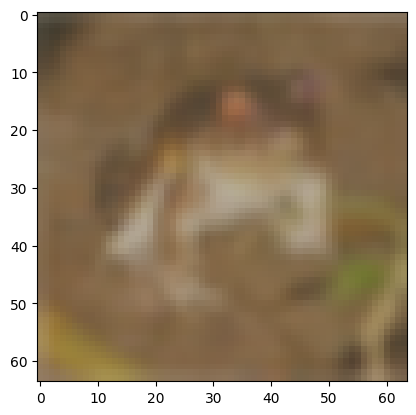

6


In [ ]:
from torchvision.utils import make_grid

for inputs, targets in train_dataset:
  out = make_grid(inputs)
  imshow(out)
  print(targets)
  break

##Paso 4 : Entrenar la red 

In [ ]:
model = CNN()

output = model(torch.randn(64, 3, 64, 64))
 

In [ ]:
def fit(model, dataloader, epochs=5):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = torch.nn.CrossEntropyLoss()
    for epoch in range(1, epochs+1):
        model.train()
        train_loss, train_acc = [], []
        bar = tqdm(dataloader['train'])
        for batch in bar:
            X, y = batch
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(X)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
            train_acc.append(acc)
            bar.set_description(f"loss {np.mean(train_loss):.5f} acc {np.mean(train_acc):.5f}")
        bar = tqdm(dataloader['test'])
        val_loss, val_acc = [], []
        model.eval()
        with torch.no_grad():
            for batch in bar:
                X, y = batch
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                loss = criterion(y_hat, y)
                val_loss.append(loss.item())
                acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
                val_acc.append(acc)
                bar.set_description(f"val_loss {np.mean(val_loss):.5f} val_acc {np.mean(val_acc):.5f}")
        print(f"Epoch {epoch}/{epochs} loss {np.mean(train_loss):.5f} val_loss {np.mean(val_loss):.5f} acc {np.mean(train_acc):.5f} val_acc {np.mean(val_acc):.5f}")
         

In [ ]:
model = CNN()
fit(model, dataloader, epochs=10)

val_loss 1.40991 val_acc 0.49453: 100%|██████████| 157/157 [00:12<00:00, 12.83it/s]


Epoch 1/10 loss 1.60246 val_loss 1.40991 acc 0.41910 val_acc 0.49453


val_loss 1.24187 val_acc 0.56111: 100%|██████████| 157/157 [00:12<00:00, 12.58it/s]


Epoch 2/10 loss 1.28287 val_loss 1.24187 acc 0.54382 val_acc 0.56111


val_loss 1.31246 val_acc 0.54538: 100%|██████████| 157/157 [00:12<00:00, 12.68it/s]


Epoch 3/10 loss 1.17901 val_loss 1.31246 acc 0.58830 val_acc 0.54538


val_loss 1.14092 val_acc 0.59793: 100%|██████████| 157/157 [00:12<00:00, 12.98it/s]


Epoch 4/10 loss 1.09118 val_loss 1.14092 acc 0.61825 val_acc 0.59793


val_loss 1.23887 val_acc 0.58151: 100%|██████████| 157/157 [00:12<00:00, 12.99it/s]


Epoch 5/10 loss 1.03557 val_loss 1.23887 acc 0.63449 val_acc 0.58151


val_loss 1.10340 val_acc 0.61624: 100%|██████████| 157/157 [00:12<00:00, 12.82it/s]


Epoch 6/10 loss 0.98957 val_loss 1.10340 acc 0.65387 val_acc 0.61624


val_loss 1.06786 val_acc 0.63595: 100%|██████████| 157/157 [00:11<00:00, 13.23it/s]


Epoch 7/10 loss 0.94973 val_loss 1.06786 acc 0.66642 val_acc 0.63595


val_loss 1.11344 val_acc 0.62082: 100%|██████████| 157/157 [00:12<00:00, 13.01it/s]


Epoch 8/10 loss 0.90707 val_loss 1.11344 acc 0.68328 val_acc 0.62082


val_loss 1.10711 val_acc 0.62480: 100%|██████████| 157/157 [00:12<00:00, 12.86it/s]


Epoch 9/10 loss 0.87451 val_loss 1.10711 acc 0.69399 val_acc 0.62480


val_loss 1.06726 val_acc 0.64062: 100%|██████████| 157/157 [00:12<00:00, 12.98it/s]

Epoch 10/10 loss 0.84198 val_loss 1.06726 acc 0.70616 val_acc 0.64062
